MeshNet architecture based on https://arxiv.org/pdf/1612.00940.pdf

"End-to-end learning of brain tissue segmentation
from imperfect labeling"
Jun 2017
Alex Fedorov∗†, Jeremy Johnson‡
, Eswar Damaraju∗†, Alexei Ozerin§
, Vince Calhoun∗†, Sergey Plis∗†

# Libraries and Global Parameters 

In [1]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.util import img_as_bool, img_as_uint, img_as_ubyte
from skimage.transform import resize
from skimage.morphology import label
import random
from random import randint 
from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, Dense, \
    UpSampling2D, BatchNormalization, add, Dropout
from keras.layers.core import Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras import backend as K
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy

model_checkpoint_file= 'meshnet_v11.h5'
submission_filename = 'meshnetv11_mesh_pred.csv'

# Root folders for test and training data
train_root = "./stage1_train"
test_root = "./stage1_test"

# Size we resize all images to
#image_size = (128,128)

img_height = 256
img_width = 256
img_channels = 1 # 1 for B&W, 3 for RGB

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

Using TensorFlow backend.


# Preparing the Data

In [2]:
# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
def import_images(root):
    dirs = os.listdir(root)
    filenames=[os.path.join(root,file_id) + "/images/"+file_id+".png" for file_id in dirs]
    images=[imread(imagefile,as_grey=True) for imagefile in filenames]
    resized_images = [ img_as_ubyte(resize(image,(img_width,img_height))) for image in images] 
    Array = np.reshape(np.array(resized_images),(len(resized_images),img_height,img_width,img_channels))
    
    print(Array.mean())
    print(Array.std())

    # Normalize inputs
    Array = (Array - Array.mean())/Array.std()

    print(Array.mean())
    print(Array.std())
    return Array, resized_images, images, filenames, dirs

train_X, resized_train_images, \
train_images, train_filenames, train_dirs = import_images(train_root)

41.0301837067
63.696880226
-5.81002907476e-18
1.0


In [3]:
## Import Training Masks
# this takes longer than the training images because we have to
# combine a lot of mask files

# This function creates a single combined mask image 
# when given a list of masks
# Probably a computationally faster way to do this...
def collapse_masks(mask_list):
    for i, mask_file in enumerate(mask_list):        
        if i != 0:
            # combine mask with previous mask in list 
            mask = np.maximum(mask, imread(os.path.join(train_root,mask_file)))
        else:
            # read first mask in
            mask = imread(os.path.join(train_root,mask_file))
    
    return mask

# Import all the masks
train_mask_dirs = [ os.path.join(path, 'masks') for path in os.listdir(train_root) ]
train_mask_files = [ [os.path.join(dir,file) for file in os.listdir(os.path.join(train_root,dir)) ]  for dir in train_mask_dirs]
train_masks = [ collapse_masks(mask_files) for mask_files in train_mask_files ]
resized_train_masks = [ img_as_bool(resize(image,(img_width,img_height))) for image in train_masks] 
train_Y = np.reshape(np.array(resized_train_masks),(len(resized_train_masks),img_height,img_width,img_channels))

Image #: 530


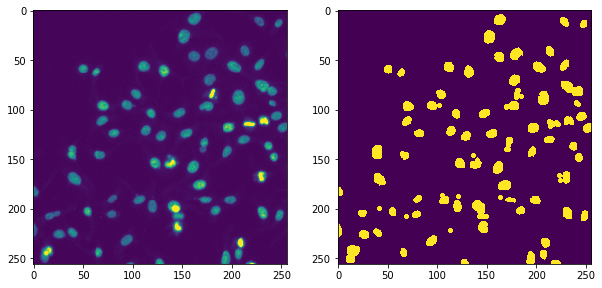

In [4]:
# Plot images side by side for a list of datasets
def plot_side_by_side(ds_list,image_num,size=(15,10)):
    print('Image #: ' + str(image_num))
    fig = plt.figure(figsize=size)

    for i in range(len(ds_list)):
        ax1 = fig.add_subplot(1,len(ds_list),i+1)
        ax1.imshow(ds_list[i][image_num])

    plt.show()
    
# Plots random corresponding images and masks
def plot_check(ds_list,rand_imgs=None,img_nums=None,size=(15,10)):
    if rand_imgs != None:
        for i in range(rand_imgs):
            plot_side_by_side(ds_list, randint(0,len(ds_list[0])-1),size=size)
    if img_nums != None:
        for i in range(len(img_nums)):
            plot_side_by_side(ds_list,img_nums[i],size=size)
    

plot_check([train_images,train_masks],rand_imgs=1,size=(10,7))


In [5]:
# Check size of arrays we are inputting to model
# This is important! We need the datasets to be as 
# small as possible to reduce computation time

# Check physical size
print(train_X.shape)
print(train_Y.shape)

# Check memory size
print(train_X.nbytes)
print(train_Y.nbytes)

# Check datatypes
print(train_X.dtype)
print(train_Y.dtype)

(670, 256, 256, 1)
(670, 256, 256, 1)
351272960
43909120
float64
bool


Image #: 263


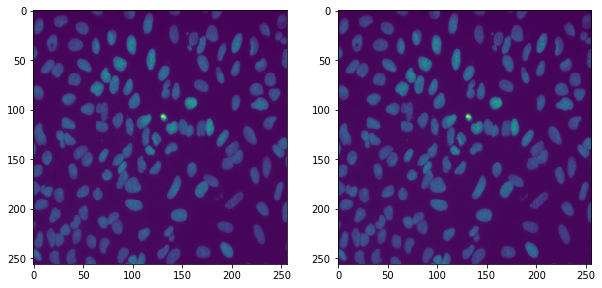

In [6]:
plot_check([resized_train_images,np.squeeze(train_X,axis=3)],rand_imgs=1,size=(10,7))


# Now Let's Build the Model

In [8]:
# Loss and metric functions for the neural net
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def create_block(x, filters=32, filter_size=(3, 3), activation='relu',dil_rate=1,dropout_rate=0.2):
    x = Conv2D(filters, filter_size, padding='same', activation=activation, dilation_rate = dil_rate) (x)
   # x = BatchNormalization() (x) 
    x = Dropout(dropout_rate) (x)
    return x


## master function for creating a net
def get_net(
        input_shape=(img_height, img_width,img_channels),
        loss=binary_crossentropy,
        lr=0.001,
        n_class=1
):
    
    inputs = Input(input_shape)
    
    # Does this help with computation?? 

    
    # Create layers
    net_body = create_block(inputs)
    net_body = create_block(net_body)
    net_body = create_block(net_body,dil_rate=2)
    net_body = create_block(net_body,dil_rate=4)
    net_body = create_block(net_body,dil_rate=8)
    net_body = create_block(net_body,dil_rate=16)
    net_body = create_block(net_body)
    classify = Conv2D(n_class,(1,1),activation='sigmoid') (net_body)

    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=Adam(lr), loss=loss, metrics=[bce_dice_loss, dice_coef])

    return model

my_model = get_net()
print(my_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
dropout_8 (Dropout)          (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
dropout_9 (Dropout)          (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
dropout_10 (Dropout)         (None, 256, 256, 32)      0         
__________

In [9]:
# Fit model

earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(model_checkpoint_file, verbose=1, save_best_only=True)
reduce_plateau = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.1,
                           patience=4,
                           verbose=1,
                        #   min_lr=0.00001,
                            epsilon=0.001,
                           mode='auto') 

results = my_model.fit(train_X, train_Y, validation_split=0.1, batch_size=1, epochs=100, verbose=1, 
                       shuffle=True, callbacks=[ earlystopper, checkpointer, reduce_plateau])

Train on 603 samples, validate on 67 samples
Epoch 1/100
602/603 [============================>.] - ETA: 1s - loss: 0.2297 - bce_dice_loss: 0.7393 - dice_coef: 0.5601
Epoch 00001: val_loss improved from inf to 0.12989, saving model to meshnet_v11.h5
603/603 [==============================] - 1072s 2s/step - loss: 0.2294 - bce_dice_loss: 0.7383 - dice_coef: 0.5607 - val_loss: 0.1299 - val_bce_dice_loss: 0.4083 - val_dice_coef: 0.7692
Epoch 2/100
602/603 [============================>.] - ETA: 1s - loss: 0.1221 - bce_dice_loss: 0.4122 - dice_coef: 0.8080
Epoch 00002: val_loss improved from 0.12989 to 0.11238, saving model to meshnet_v11.h5
603/603 [==============================] - 1063s 2s/step - loss: 0.1219 - bce_dice_loss: 0.4119 - dice_coef: 0.8082 - val_loss: 0.1124 - val_bce_dice_loss: 0.3005 - val_dice_coef: 0.8589
Epoch 3/100
602/603 [============================>.] - ETA: 1s - loss: 0.1090 - bce_dice_loss: 0.3628 - dice_coef: 0.8309
Epoch 00003: val_loss improved from 0.11238 t

Epoch 23/100
602/603 [============================>.] - ETA: 1s - loss: 0.0688 - bce_dice_loss: 0.2283 - dice_coef: 0.8918
Epoch 00023: val_loss improved from 0.06450 to 0.06151, saving model to meshnet_v11.h5
603/603 [==============================] - 1105s 2s/step - loss: 0.0688 - bce_dice_loss: 0.2283 - dice_coef: 0.8918 - val_loss: 0.0615 - val_bce_dice_loss: 0.1889 - val_dice_coef: 0.9129
Epoch 24/100
602/603 [============================>.] - ETA: 1s - loss: 0.0661 - bce_dice_loss: 0.2212 - dice_coef: 0.8950
Epoch 00024: val_loss did not improve
603/603 [==============================] - 1066s 2s/step - loss: 0.0664 - bce_dice_loss: 0.2216 - dice_coef: 0.8948 - val_loss: 0.0685 - val_bce_dice_loss: 0.2014 - val_dice_coef: 0.9030
Epoch 25/100
602/603 [============================>.] - ETA: 1s - loss: 0.0680 - bce_dice_loss: 0.2266 - dice_coef: 0.8907
Epoch 00025: val_loss did not improve
603/603 [==============================] - 1098s 2s/step - loss: 0.0681 - bce_dice_loss: 0.227

KeyboardInterrupt: 

In [24]:
type(train_X[0,0,0,0
            ])

numpy.float64

In [25]:
## Import Test Data and Make Predictions with Model

# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
test_X, resized_test_images, \
test_images, test_filenames, test_dirs = import_images(test_root)


# Load model and make predictions on test data
final_model = load_model(model_checkpoint_file, custom_objects={'dice_coef': dice_coef, 'bce_dice_loss':bce_dice_loss})
preds_test = final_model.predict(test_X, verbose=1)

preds_test_t = (preds_test > 0.5) 

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (test_images[i].shape[0], test_images[i].shape[1]), 
                                       mode='constant', preserve_range=True))

preds_test_upsampled_bool = [ (mask > 0.5).astype(bool) for mask in preds_test_upsampled ]


53.2248368483
74.7946300436
4.15266112095e-17
1.0
65/65 [==============================] - 32s 497ms/step


Image #: 45


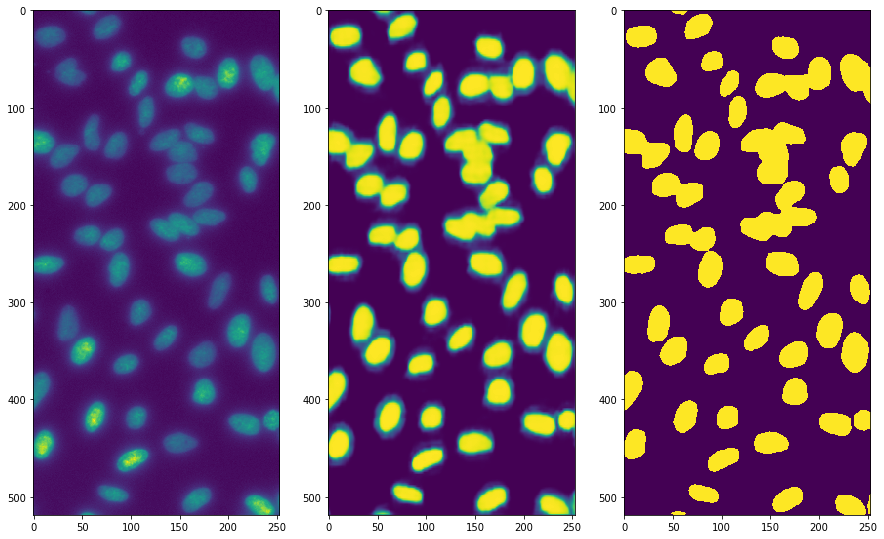

Image #: 24


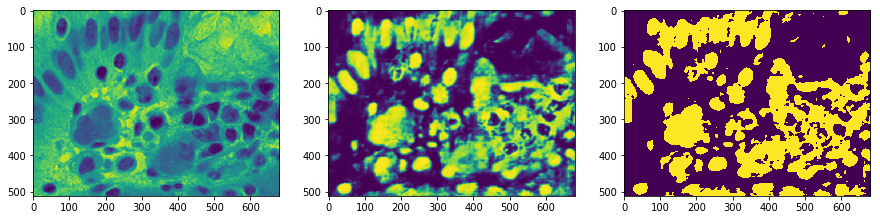

In [29]:
plot_check([test_images,preds_test_upsampled,preds_test_upsampled_bool],rand_imgs=2)

In [30]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

        
def generate_prediction_file(image_names,predictions,filename):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(image_names):
        rle = list(prob_to_rles(predictions[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    sub.to_csv(filename, index=False)

In [31]:
generate_prediction_file(test_dirs,preds_test_upsampled_bool,submission_filename)

Ideas
 - Experiment with compression of training data. Am I preserving as much detail
    as I can in dtype np.uint8 (values of 0 to 255) ?
- Color vs B&W?
- Combine mask and prediction images to show false positives and negatives
- What is the best resizing method? Reflect??
- Put computer vision / threshold method output as an input to neural net
- Output intermediate layers for inspection
- Crop images to train networks faster for testing ??
- Take random crops of images to create, and then combine outputs in the end
- Is combining the masks really the best thing to do? Should I be keeping the individual cells separate?
- Pseudo-labelled data